Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 13.  Winter 2026.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from tqdm.keras import TqdmCallback

# 2-D Convolutional Neural Network

2-D CNNs are useful for image classification.  In an engineering setting they can be useful for real-time monitoring of prodcuts on an assembly line.  Since they are typically used for image classification, I don't have a great example to show you.  Training an image classifier in lecture is going to be prohibitively expensive.  I can, however, show you the synthax for building a 2-D CNN.  Below is the <code>Keras</code> synthax that would build the CNN example at the end of lecture.

In [2]:
model = keras.Sequential([
  keras.layers.Input((32, 32, 3)),
  keras.layers.Conv2D(6, (3, 3), activation='relu', padding='same'), #convolution layer with 6 (3 x 3) filters and 0-padding
  keras.layers.MaxPooling2D((2, 2)), #max pool layer with a 2 x 2 filter

  keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same'), #convolution layer with 12 (3 x 3) filters and 0-padding
  keras.layers.MaxPooling2D((2, 2)), #max pool layer with a 2 x 2 filter

  keras.layers.Conv2D(24, (3, 3), activation='relu', padding='same'), #convolution layer with 24 (3 x 3) filters and 0-padding
  keras.layers.MaxPooling2D((2, 2)), #max pool layer with a 2 x 2 filter

  keras.layers.Flatten(), #flatten the convolution output from a series of matrices into a single 1-D vector
  keras.layers.Dense(500, activation='relu'), #feed the flattened convolutions through a dense layer with 500 neurons
  keras.layers.Dense(100, activation='softmax')  #for classifications, the final layer works best with a 'softmax' activation, not 'linear' as we use for regression (we'll talk about this later)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 24)       │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       192,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,044 (961.11 KB)

 Trainable params: 246,044 (961.11 KB)

 Non-trainable params: 0 (0.00 B)

Above <code>padding='same'</code> means that the layer will add zeros to keep the convolution the same shape as the input.  Using <code>padding='valid'</code> means that no padding is used.

#1-D Convolutional Neural Network

Here we'll go back to our aqueous solvation data set.  In that data set is the aqueous solubility for many chemical compounds.  As part of that data set we have the SMILES string for each compound, which encodes its structure.  We'll talk about this SMILES string later along with how to process it.

For now, we'll build a 1-D CNN that aims to find patterns in the SMILES string (and by extension its structure) to predict its aqueous solubility.  Can we do any better than using all of those 17 features with multiple linear and polynomial regression in HW2?  Let's see.

We'll first encode the SMILES string into a numerical vector.  Don't worry about the details here, the point is that we end up with a numerical vector that represents structure and we'll try to find patterns in it to predict solutbility.  We'll talk about SMILES strings and how to featurize them when we get to classification.  Keep in mind that this is the first offering of this course and the ordering of material clearly is not optimized yet.

This deminstration is based off of the following chapter in Andrew White's online book: <url>https://dmol.pub/dl/NLP.html?highlight=rnn</url>.

In [3]:
#load training and testing data
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_test.csv')

#filter out long smiles
max_smile_length = 96
mask_train = [len(s) <= max_smile_length for s in df_train['SMILES']]
print('Removed '+str(df_train.shape[0] - sum(mask_train))+' long SMILES strings from training data.')
filtered_training_data = df_train[mask_train]

mask_test = [len(s) <= max_smile_length for s in df_test['SMILES']]
print('Removed '+str(df_test.shape[0] - sum(mask_test))+' long SMILES strings from test data.')
filtered_test_data = df_test[mask_test]

Removed 257 long SMILES strings from training data.
Removed 28 long SMILES strings from test data.


We actually used these data sets in HW2.  Let's remind ourself about the performance.  We used multiple linear regression on 17 numerical features for a molecule to predict its aqueous solubility.  This will be our baseline model.

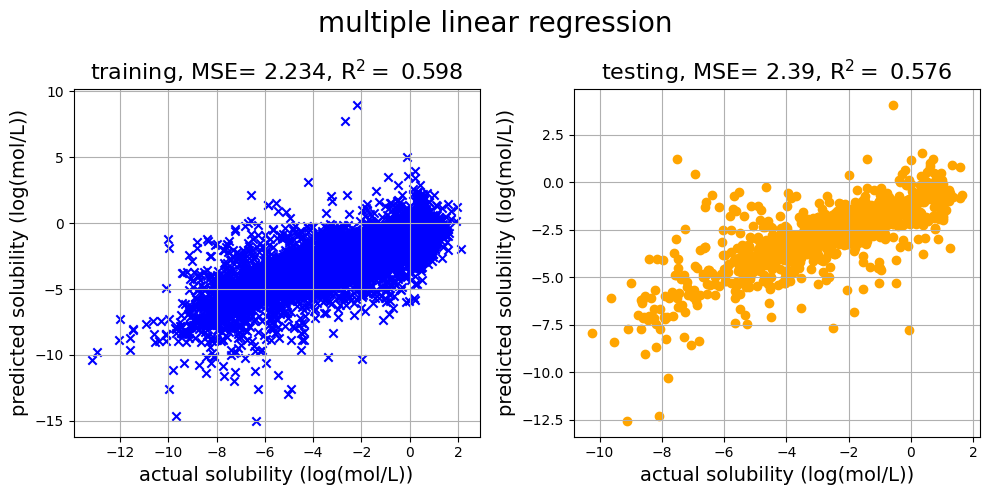

In [4]:
#select the features starting at MolWt and going to the end
starting_feature = filtered_training_data.columns.get_loc("MolWt")
features = filtered_training_data.columns[starting_feature:]

#build the training and test feature matrices
X_train = filtered_training_data[features].values
X_test = filtered_test_data[features].values

#build the training and test targets
y_train = filtered_training_data["Solubility"].values
y_test = filtered_test_data["Solubility"].values

#set up and fit the model
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

#make predictions on the training and test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#calculate the MSE on the training and test data
mse_train = sklearn.metrics.mean_squared_error(y_pred_train, y_train)
mse_test = sklearn.metrics.mean_squared_error(y_pred_test, y_test)

#calculate R^2 on the training and test data
R2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
R2_test = sklearn.metrics.r2_score(y_test, y_pred_test)

#set up plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#plot the training predictions against actual solubility
ax[0].scatter(y_train, y_pred_train, color='b', marker='x',label='train')
ax[0].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
ax[0].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
ax[0].grid()
ax[0].set_title('training, MSE= '+str(np.round(mse_train,decimals=3))+', R$^2=$ '+str(np.round(R2_train,decimals=3)),fontsize=16)

#plot the test predictions against the actual solubility
ax[1].scatter(y_test, y_pred_test, color='orange', marker='o',label='test')
ax[1].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
ax[1].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
ax[1].grid()
ax[1].set_title('testing, MSE= '+str(np.round(mse_test, decimals=3))+', R$^2=$ '+str(np.round(R2_test, decimals=3)),fontsize=16)
fig.suptitle('multiple linear regression',fontsize=20)
plt.tight_layout()
plt.show()

Now instead of using these 17 numerical features, we'll try to predict the solubility from the structure using a CNN.  The structure is encoded in the SMILES string.  We'll take the SMILES string for each molecule and convert it to a string of integers that the neural network can use.  This is called 'tokenizing'.  Because the SMILES string will be different lengths for different molecules, we'll set a maximum length (for ease of demonstration) and any string that are less than the maximum length will get padded at the end with zeros.  Let's first look at a few SMILES strings.

In [5]:
print(filtered_training_data['SMILES'][0:5])

0                   Fc1ccc(Oc2ccnc3cc(Cl)cc(Cl)c23)cc1
1                     CC1=NC(=C(S1)C(=O)NC2=CC=CC=C2)C
2                         Cc1cc(O)c(Cc2ccccc2)c(C)c1Cl
3                                      Cc1ccc(N)c(C)c1
4    COC1=CC=C2C=C(C=CC2=C1)C(C)C(=O)OCC(=O)N(C)CC(...
Name: SMILES, dtype: object


Now we'll convert each SMILES string into a vector of integers.  We map each character in the string to a unique integer.

In [6]:
#figure out how many unique characters there are across all the SMILES
all_SMILES = pd.concat([filtered_training_data['SMILES'], filtered_test_data['SMILES']], ignore_index=True)
unique_count = len(set().union(*all_SMILES))+1

#the tokenizer will convert our characters into numbers
#filers='' means we won't filter any characters, every character in the SMILES string counts
#char_level=True means that we'll break the SMILES strings down into individual characters (as opposed to words for natural language processing)
#lower=False means that we distinguish between upper and lower case (lower case means the atom is in an aromatic ring)
tokenizer = tf.keras.preprocessing.text.Tokenizer(unique_count, filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(all_SMILES)

#we now convert our training and test SMILES to integer sequences with the tokenizer
train_seqs = tokenizer.texts_to_sequences(filtered_training_data['SMILES'])
test_seqs = tokenizer.texts_to_sequences(filtered_test_data['SMILES'])

#finally, we pad our sequences with zeros at the end so each is the same length
padded_train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
padded_test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

#let's look at some example SMILES and their final integer sequences
for i in range(5):
  print('SMILES string: ', df_train['SMILES'][i])
  print('padded sequence: ', padded_train_seqs[i])

SMILES string:  Fc1ccc(Oc2ccnc3cc(Cl)cc(Cl)c23)cc1
padded sequence:  [22  2  7  2  2  2  3  5  2  9  2  2 19  2 13  2  2  3  1 12  4  2  2  3
  1 12  4  2  9 13  4  2  2  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
SMILES string:  CC1=NC(=C(S1)C(=O)NC2=CC=CC=C2)C
padded sequence:  [ 1  1  7  6  8  1  3  6  1  3 14  7  4  1  3  6  5  4  8  1  9  6  1  1
  6  1  1  6  1  9  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
SMILES string:  Cc1cc(O)c(Cc2ccccc2)c(C)c1Cl
padded sequence:  [ 1  2  7  2  2  3  5  4  2  3  1  2  9  2  2  2  2  2  9  4  2  3  1  4
  2  7  1 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Alright, now we finally have a numerical sequence that in some way represents the structure of our molecule.  Let's build a CNN to read in these sequences, try to find patterns, and predict the aqueous solubility.  

Here we'll have 3 convolutional layers.  The first will have 10 filters that are 3 elements long.  We'll pad the input with zeros so that the input and output sequences from the convolution are the same.  We'll use a ReLU activaton.  After that we'll do a max pool with size 2, which means the output will be condensed in half.  

The next convolutional layer will be similar to the first, but it will have 20 filters.  The output will again be reduced in half by a max pool layer.  The last convolutional layer will have 30 filters and we'll cut our output down even more with a max pool of size 4 before feeding into the dense layer.

We finally flatten the outputs from the convolutional layer into a single dimension so we can feed it through a dense layer with 40 neurons and a ReLU activation.  The final predictions are done by our linear output layer.

We'll fit with an ADAM optimizer and use early stopping where 20% of the training data is held back for validation during training.

In [7]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  #keras.layers.Embedding(input_dim=128, output_dim=16, input_length=96),

  keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=4),

  keras.layers.Flatten(),
  keras.layers.Dense(40, activation='relu'),

  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 30)         │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


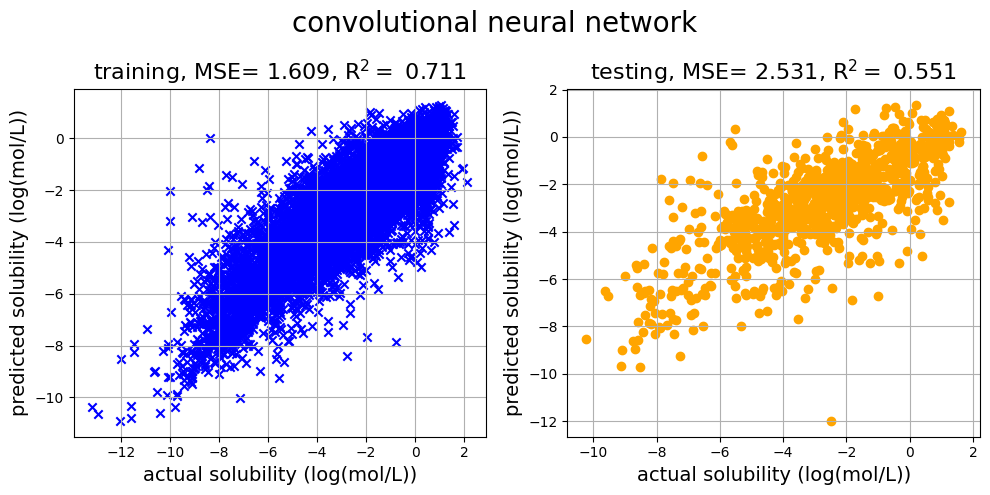

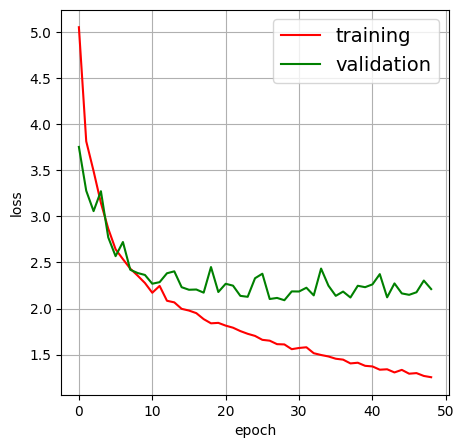

In [8]:
#make predictions on the training and test data
y_pred_train = model.predict(padded_train_seqs)
y_pred_test = model.predict(padded_test_seqs)

#calculate the MSE on the training and test data
mse_train = sklearn.metrics.mean_squared_error(y_pred_train, y_train)
mse_test = sklearn.metrics.mean_squared_error(y_pred_test, y_test)

#calculate R^2 on the training and test data
R2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
R2_test = sklearn.metrics.r2_score(y_test, y_pred_test)

#set up plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#plot the training predictions against actual solubility
ax[0].scatter(y_train, y_pred_train, color='b', marker='x',label='train')
ax[0].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
ax[0].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
ax[0].grid()
ax[0].set_title('training, MSE= '+str(np.round(mse_train,decimals=3))+', R$^2=$ '+str(np.round(R2_train,decimals=3)),fontsize=16)

#plot the test predictions against the actual solubility
ax[1].scatter(y_test, y_pred_test, color='orange', marker='o',label='test')
ax[1].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
ax[1].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
ax[1].grid()
ax[1].set_title('testing, MSE= '+str(np.round(mse_test, decimals=3))+', R$^2=$ '+str(np.round(R2_test, decimals=3)),fontsize=16)
fig.suptitle('convolutional neural network',fontsize=20)
plt.tight_layout()


fgi2, ax2 = plt.subplots(1, 1, figsize=(5, 5))

ax2.plot(history.history['loss'], label='training', color='r')
ax2.plot(history.history['val_loss'], label='validation',color='g')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(fontsize=14)
ax2.grid()

plt.show()

This gives similar performance to multiple linear regression.  But!  Multiple linear regression used 17 features.  Here we just used a single string with the molecule's structure (fairly crudely) encoded in it.  Not bad, I'd say.